In [1]:
# %% [markdown]
# # AlphaCare Insurance — Statistical Analytics Notebook
#
# This notebook runs an end-to-end analytics flow:
# 1. Load data
# 2. Quick EDA and the three key plots
# 3. Distribution diagnostics
# 4. Hypothesis testing: t-test, Mann-Whitney, bootstrap CI
# 5. ANOVA + Tukey example
# 6. Simple regression modeling and evaluation
# 7. Optional SHAP explainability (if installed)

import os
from pathlib import Path
import sys
sys.path.append("src")
sys.path.append(str(Path.cwd() / "src"))
import pandas as pd
# utility modules (you should have these files in src/)
from src.data_loader import load_data
from src.eda_utils import generate_key_plots
# the 3 consolidated stats modules we created
# put them under src/stats as: distributions.py, hypothesis.py, modeling.py
from src.stats import distributions as dist
from src.stats import hypothesis as ht
from src.stats import modeling as ml

# %% [markdown]
# ## Configuration
DATA_PATH = "../data/Raw/MachineLearningRating_v3.txt"  # update if needed
OUT_DIR = "output"
os.makedirs(OUT_DIR, exist_ok=True)

# %%
# 1. Load data (robust)
print("Loading data from:", DATA_PATH)
df = load_data(DATA_PATH)
print("Loaded rows:", df.shape[0], "columns:", df.shape[1])

# quick header preview
display(df.columns.tolist()[:40])
# show first few rows
df.head(2)


Loading data from: ../data/Raw/MachineLearningRating_v3.txt
Loaded rows: 1000098 columns: 52


['UnderwrittenCoverID',
 'PolicyID',
 'TransactionMonth',
 'IsVATRegistered',
 'Citizenship',
 'LegalType',
 'Title',
 'Language',
 'Bank',
 'AccountType',
 'MaritalStatus',
 'Gender',
 'Country',
 'Province',
 'PostalCode',
 'MainCrestaZone',
 'SubCrestaZone',
 'ItemType',
 'Mmcode',
 'VehicleType',
 'RegistrationYear',
 'Make',
 'Model',
 'Cylinders',
 'CubicCapacity',
 'Kilowatts',
 'BodyType',
 'NumberOfDoors',
 'VehicleIntroDate',
 'CustomValueEstimate',
 'AlarmImmobiliser',
 'TrackingDevice',
 'CapitalOutstanding',
 'NewVehicle',
 'WrittenOff',
 'Rebuilt',
 'Converted',
 'CrossBorder',
 'NumberOfVehiclesInFleet',
 'SumInsured']

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0


In [2]:

# %% [markdown]
# ## Quick housekeeping
# Ensure common numeric columns exist and coerce when needed
num_cols = ["TotalPremium", "TotalClaims", "CalculatedPremiumPerTerm", "SumInsured"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# If TransactionMonth parsed, else try to convert here
if "TransactionMonth" in df.columns and not pd.api.types.is_datetime64_any_dtype(df["TransactionMonth"]):
    df["TransactionMonth"] = pd.to_datetime(df["TransactionMonth"], errors="coerce")

# Basic derived columns
df["claim_flag"] = (df["TotalClaims"].fillna(0) > 0).astype(int)
df["vehicle_age"] = None
if "RegistrationYear" in df.columns:
    try:
        # approximate vehicle age using transaction year minus registration year
        df["vehicle_age"] = df["TransactionMonth"].dt.year - pd.to_numeric(df["RegistrationYear"], errors="coerce")
    except Exception:
        df["vehicle_age"] = None

# show basic summary
display(df[num_cols].describe(include="all").T)


,count,mean,std,min,25%,50%,75%,max
TotalPremium,1000098.0,61.905496,2.302845e+02,-782.576754,0.0000,2.178333,21.929825,6.528260e+04
TotalClaims,1000098.0,64.861190,2.384075e+03,-12002.412281,0.0000,0.000000,0.000000,3.930921e+05
CalculatedPremiumPerTerm,1000098.0,117.875691,3.997017e+02,0.000000,3.2248,8.436900,90.000000,7.442217e+04
SumInsured,1000098.0,604172.732589,1.508332e+06,0.010000,5000.0000,7500.000000,250000.000000,1.263620e+07


Generating Plot 1: Risk Exposure by Province...


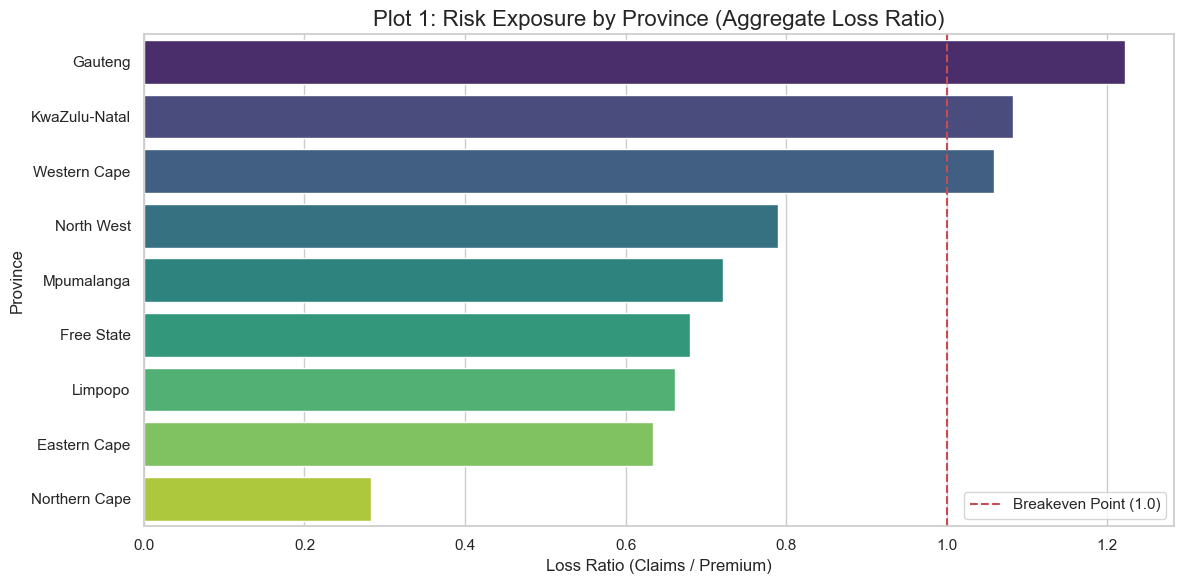

Generating Plot 2: Claim Severity by Vehicle Type...


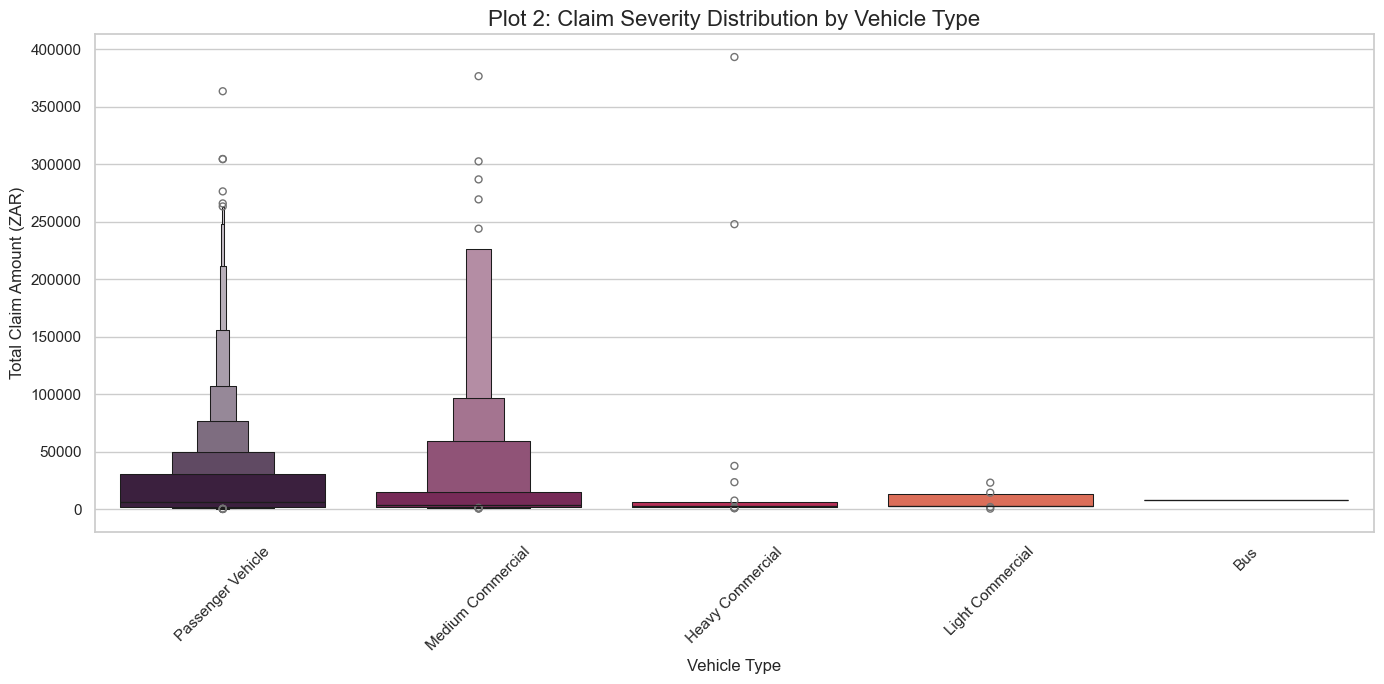

Generating Plot 3: Monthly Margin...


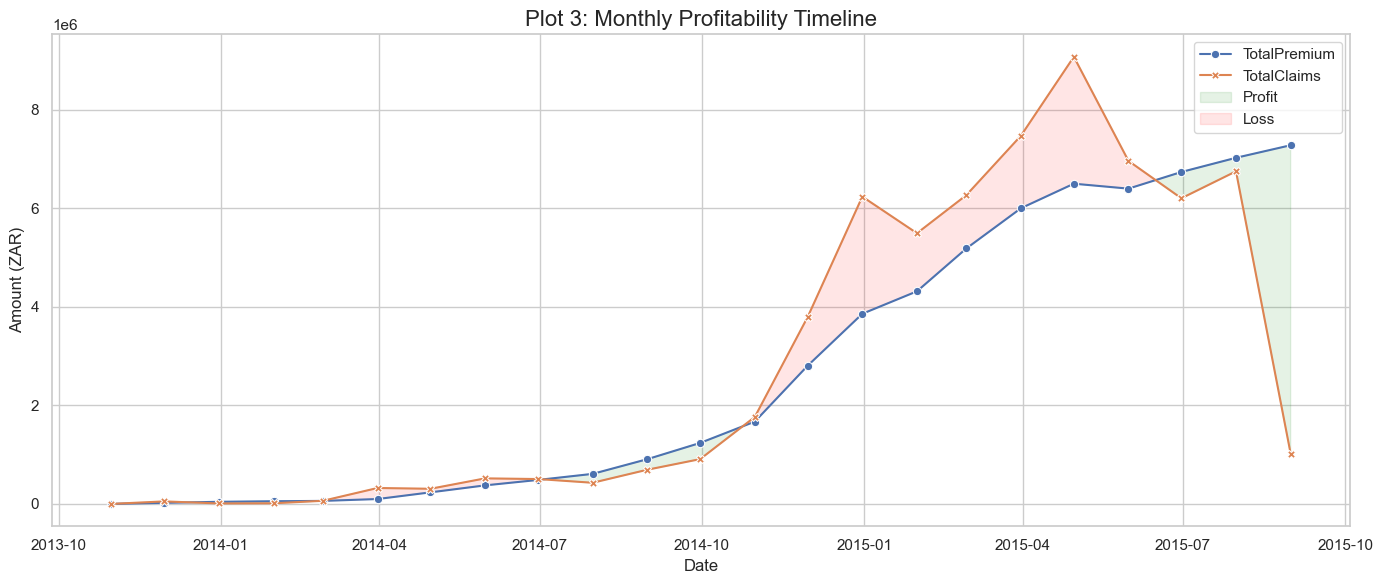

Generating and saving plots...


AttributeError: 'NoneType' object has no attribute 'items'

In [5]:

# %% [markdown]
# ## 2. Generate the three polished EDA plots
# The function returns Matplotlib figure objects. We show and save them.
figs = generate_key_plots(df)
print("Generating and saving plots...")
for name, fig in figs.items():
    print("Saving plot:", name)
    # safe filename
    fname = f"{OUT_DIR}/{name}.png"
    try:
        fig.savefig(fname, bbox_inches="tight")
        print("Saved to", fname)
    except Exception as e:
        print("Could not save figure:", e)
    display(fig)
    # close figure to free memory
    import matplotlib.pyplot as plt
    plt.close(fig)


Distribution summary for TotalClaims:
{'mean': np.float64(64.86118977410388), 'median': np.float64(0.0), 'std': np.float64(2384.07469450152), 'skewness': np.float64(69.93301354519751), 'kurtosis': np.float64(6791.892207344419)}
Shapiro-Wilk test (sample) stat=0.0068, p=1.086e-95


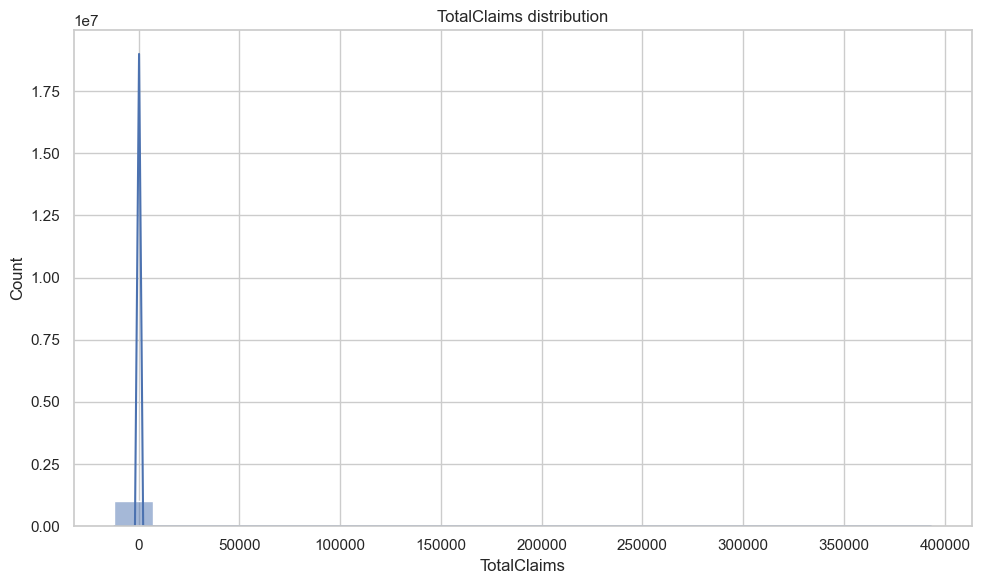

In [4]:

# %% [markdown]
# ## 3. Distribution diagnostics: TotalClaims and TotalPremium
# We'll check skewness, kurtosis, and normality for TotalClaims (likely skewed)
if "TotalClaims" in df.columns:
    series = df["TotalClaims"].fillna(0)
    print("Distribution summary for TotalClaims:")
    print(dist.distribution_summary(series))

    stat_p = dist.normality_test(series)
    if stat_p is not None:
        stat, p = stat_p
        print(f"Shapiro-Wilk test (sample) stat={stat:.4f}, p={p:.4g}")
    else:
        print("Normality test not available")

    # plot distribution (large samples may be slow)
    p = dist.plot_distribution(series, title="TotalClaims distribution")
    if p:
        p.show()


In [7]:

# %% [markdown]
# ## 4. Hypothesis testing examples
# Example 1: Compare claim frequency between two provinces
# Pick two provinces with enough data
if "Province" in df.columns and "TotalClaims" in df.columns:
    counts = df["Province"].value_counts()
    top4 = counts.index[:4].tolist()
    print("Top 4 provinces by row count:", top4)

    if len(top4) >= 4:
        provA, provB = top4[0], top4[1]
        A = df[df["Province"] == provA]["TotalClaims"].fillna(0)
        B = df[df["Province"] == provB]["TotalClaims"].fillna(0)

        print(f"Running tests on provinces: {provA} vs {provB}")
        t_res = ht.t_test(A, B)
        mw_res = ht.mann_whitney(A, B)
        ci = ht.bootstrap_ci(A, B, n=2000)

        if t_res is not None:
            print("t-test:", t_res.statistic, "p=", t_res.pvalue)
        if mw_res is not None:
            print("Mann-Whitney:", mw_res.statistic, "p=", mw_res.pvalue)
        if ci is not None:
            print("Bootstrap 95% CI for mean diff:", ci)

        # effect size
        d = ht.cohens_d(A, B)
        print("Cohen's d:", d)

        # translate insight
        p_val = t_res.pvalue if (t_res is not None) else (mw_res.pvalue if mw_res is not None else None)
        insight = ht.translate_insight(f"Province {provA} vs {provB}", p_val, effect=d)
        print("Insight:", insight)


Top 4 provinces by row count: ['Gauteng', 'Western Cape', 'KwaZulu-Natal', 'North West']
Running tests on provinces: Gauteng vs Western Cape
t-test: 1.865214349648601 p= 0.0621523145227998
Mann-Whitney: 33675332603.0 p= 5.804575076767628e-14
Bootstrap 95% CI for mean diff: [-3.45733672 31.00397708]
Cohen's d: 0.005465632358989413
Insight: {'What': 'Province Gauteng vs Western Cape found p=0.0622', 'Interpretation': 'No significant difference', 'EffectSize': np.float64(0.005465632358989413), 'BusinessAction': 'No immediate business action required.'}


In [8]:


# %% [markdown]
# ## 5. ANOVA example across VehicleType (if available)
import  os
import sys
sys.path.append("../src")

if "VehicleType" in df.columns and "TotalClaims" in df.columns:
    groups = []
    # choose top 4 vehicle types for stability
    top_vehicle_types = df["VehicleType"].value_counts().index[:4].tolist()
    print("ANOVA vehicle groups:", top_vehicle_types)
    for vt in top_vehicle_types:
        groups.append(df.loc[df["VehicleType"] == vt, "TotalClaims"].fillna(0))
    anova_res = ht.run_anova(*groups)
    if anova_res is not None:
        print("ANOVA F-statistic:", anova_res.statistic, "p:", anova_res.pvalue)

    # Tukey test with statsmodels if available
    try:
        import statsmodels.api as sm
        from statsmodels.stats.multicomp import pairwise_tukeyhsd
        temp = df[df["VehicleType"].isin(top_vehicle_types)][["VehicleType", "TotalClaims"]].dropna()
        tukey = pairwise_tukeyhsd(endog=temp["TotalClaims"], groups=temp["VehicleType"], alpha=0.05)
        print(tukey.summary())
    except Exception as e:
        print("Tukey HSD not run:", e)


ANOVA vehicle groups: ['Passenger Vehicle', 'Medium Commercial', 'Heavy Commercial', 'Light Commercial']
ANOVA F-statistic: 1.6442920379642791 p: 0.17677951862937993
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1            group2      meandiff p-adj    lower    upper   reject
-----------------------------------------------------------------------------
 Heavy Commercial  Light Commercial -85.8892 0.2588 -206.4122  34.6338  False
 Heavy Commercial Medium Commercial -25.0868 0.8285 -100.5669  50.3934  False
 Heavy Commercial Passenger Vehicle -37.8069 0.5203 -108.8708   33.257  False
 Light Commercial Medium Commercial  60.8025 0.4097  -40.2041  161.809  False
 Light Commercial Passenger Vehicle  48.0823 0.5862  -49.6682 145.8328  False
Medium Commercial Passenger Vehicle -12.7201  0.619  -39.6758  14.2355  False
-----------------------------------------------------------------------------


Rows with claims: 2788
Regression metrics error: got an unexpected keyword argument 'squared'
Regression metrics: None


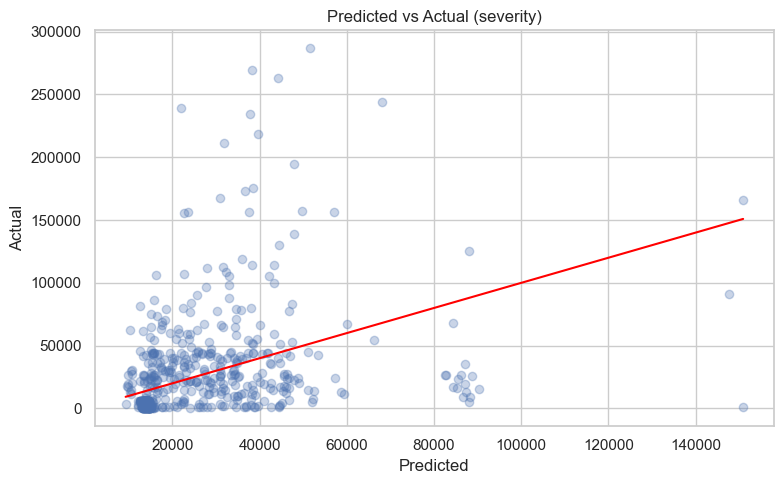

In [9]:

# %% [markdown]
# ## 6. Simple regression example: Predict TotalClaims (severity) for claims > 0
# We'll create a small feature set and run linear regression with train/test split
from sklearn.model_selection import train_test_split

if "TotalClaims" in df.columns:
    severity_df = df[df["TotalClaims"].fillna(0) > 0].copy()
    print("Rows with claims:", len(severity_df))

    # Select features reasonably available
    candidate_features = []
    for c in ["CalculatedPremiumPerTerm", "SumInsured", "vehicle_age", "Kilowatts", "cubiccapacity"]:
        if c in severity_df.columns:
            candidate_features.append(c)

    # fallback: if none present, use TotalPremium
    if not candidate_features and "TotalPremium" in severity_df.columns:
        candidate_features = ["TotalPremium"]

    if candidate_features:
        X = severity_df[candidate_features].fillna(0)
        y = severity_df["TotalClaims"].astype(float).fillna(0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        lin = ml.train_linear(X_train, y_train)
        preds = lin.predict(X_test)

        metrics = ml.regression_metrics(y_test, preds)
        print("Regression metrics:", metrics)

        # quick residual plot
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.scatter(preds, y_test, alpha=0.3)
        plt.plot([preds.min(), preds.max()], [preds.min(), preds.max()], color="red")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Predicted vs Actual (severity)")
        plt.tight_layout()
        plt.show()
    else:
        print("No candidate features found for regression. Consider engineering features.")


/Users/admin/week3/alpha-care-insurance/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


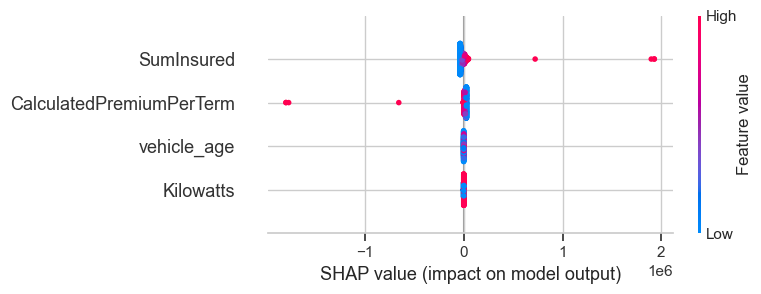

In [10]:

# %% [markdown]
# ## 7. Optional: SHAP explainability for the linear model or other models
# This block runs only if shap is installed and the model exists
try:
    import shap
    shap_installed = True
except Exception:
    shap_installed = False

if shap_installed and 'lin' in locals():
    try:
        explainer = shap.Explainer(lin, X_train)
        shap_values = explainer(X_test)
        # summary plot (Matplotlib)
        shap.summary_plot(shap_values, X_test)
    except Exception as e:
        print("SHAP explainability failed:", e)
else:
    print("SHAP not available or no model to explain. To enable, pip install shap")


In [11]:

# %% [markdown]
# ## 8. Save a short report CSV with key metrics
report = {
    "rows": len(df),
    "num_claims": df["claim_flag"].sum() if "claim_flag" in df.columns else None,
    "overall_loss_ratio": (df["TotalClaims"].sum() / df["TotalPremium"].sum()) if ("TotalClaims" in df.columns and "TotalPremium" in df.columns) else None
}
report_df = pd.DataFrame([report])
report_csv = os.path.join(OUT_DIR, "summary_report.csv")
report_df.to_csv(report_csv, index=False)
print("Saved summary report to", report_csv)

# %% [markdown]
# ## End of notebook
# Use the code blocks above as templates. Copy them into smaller scripts if you want to automate
# via DVC stages: data_load -> eda -> stats -> modeling


Saved summary report to output/summary_report.csv


In [3]:
import os

print(os.listdir("../src/stats"))


['hypothesis.py', 'distributions.py', 'modeling.py']
